                            0
累积净值                    13.85
年化收益                   16.64%
最大回撤                  -27.81%
最大回撤开始时间  2018-02-05 00:00:00
最大回撤结束时间  2019-01-23 00:00:00
年化收益/回撤比                  0.6


/var/folders/n1/6srm3wcx1tb8rzfsdn3wvp640000gn/T/ipykernel_37770/1585545227.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['style'].fillna(method='ffill', inplace=True)


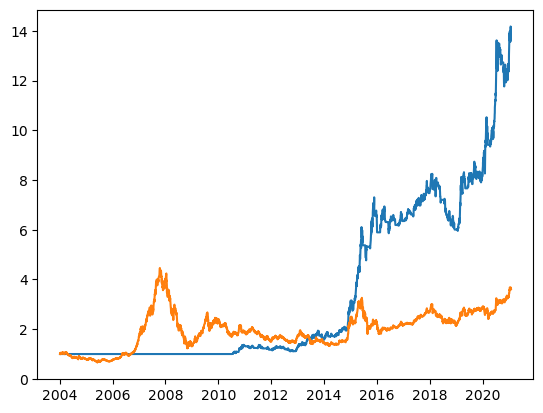

     candle_end_time  big_open  big_close   big_amp  small_open  small_close  small_amp   big_mom  small_mom    pos trade_time  strategy_amp_adjust   big_net  small_net  strategy_net
4139      2021-01-14   3863.10    3811.22 -0.016010     3101.96      3089.18  -0.013136  0.093481   0.119009  small        NaT            -0.013136  3.592779        NaN     13.584797
4140      2021-01-15   3825.54    3817.93  0.001761     3074.00      3089.94   0.000246  0.078651   0.109247  small        NaT             0.000246  3.599104        NaN     13.588139
4141      2021-01-18   3807.99    3849.40  0.008243     3078.03      3149.20   0.019178  0.097330   0.132508  small        NaT             0.019178  3.628771        NaN     13.848737
4142      2021-01-19   3855.75    3808.69 -0.010576     3146.27      3084.49  -0.020548  0.081320   0.070097  small        NaT            -0.020607  3.590394        NaN     13.563358
4143      2021-01-20   3813.91    3814.65  0.001565     3106.35      3204.93   0.0390

In [1]:
"""轮动策略"""

import pandas as pd
import numpy as np
from function import *
import matplotlib.pyplot as plt

pd.set_option('expand_frame_repr', False)  # 当列太多时不换行
pd.set_option('display.max_rows', 5000)  # 最多显示数据的行数

# 读取数据
df_big = pd.read_csv('sh000016.csv', encoding='gbk', parse_dates=['candle_end_time'])
df_small = pd.read_csv('sz399006.csv', encoding='gbk', parse_dates=['candle_end_time'])

# 设置参数
trade_rate = 0.6 / 10000  # 场内基金万分之0.6，买卖手续费相同，无印花税
momentum_days = 20  # 计算多少天的动量
# 计算大小盘每天的涨跌幅amplitude
df_big['big_amp'] = df_big['close'] / df_big['close'].shift(1) - 1
df_small['small_amp'] = df_small['close'] / df_small['close'].shift(1) - 1
# 重命名行
df_big.rename(columns={'open': 'big_open', 'close': 'big_close'}, inplace=True)
df_small.rename(columns={'open': 'small_open', 'close': 'small_close'}, inplace=True)
# 合并数据
df = pd.merge(left=df_big[['candle_end_time', 'big_open', 'big_close', 'big_amp']], left_on=['candle_end_time'],
              right=df_small[['candle_end_time', 'small_open', 'small_close', 'small_amp']],
              right_on=['candle_end_time'], how='left')
# 计算N日的动量momentum
df['big_mom'] = df['big_close'].pct_change(periods=momentum_days)
df['small_mom'] = df['small_close'].pct_change(periods=momentum_days)
# 风格变换条件
df.loc[df['big_mom'] > df['small_mom'], 'style'] = 'big'
df.loc[df['big_mom'] < df['small_mom'], 'style'] = 'small'
df.loc[(df['big_mom'] < 0) & (df['small_mom'] < 0), 'style'] = 'empty'
# 相等时维持原来的仓位。
df['style'].fillna(method='ffill', inplace=True)
# 收盘才能确定风格，实际的持仓pos要晚一天。
df['pos'] = df['style'].shift(1)
# 删除持仓为nan的天数（创业板2010年才有）
df.dropna(subset=['pos'], inplace=True)
# 计算策略的整体涨跌幅strategy_amp
df.loc[df['pos'] == 'big', 'strategy_amp'] = df['big_amp']
df.loc[df['pos'] == 'small', 'strategy_amp'] = df['small_amp']
df.loc[df['pos'] == 'empty', 'strategy_amp'] = 0

# 调仓时间
df.loc[df['pos'] != df['pos'].shift(1), 'trade_time'] = df['candle_end_time']
# 将调仓日的涨跌幅修正为开盘价买入涨跌幅（并算上交易费用，没有取整数100手，所以略有误差）
df.loc[(df['trade_time'].notnull()) & (df['pos'] == 'big'), 'strategy_amp_adjust'] = df['big_close'] / (
        df['big_open'] * (1 + trade_rate)) - 1
df.loc[(df['trade_time'].notnull()) & (df['pos'] == 'small'), 'strategy_amp_adjust'] = df['small_close'] / (
        df['small_open'] * (1 + trade_rate)) - 1
df.loc[df['trade_time'].isnull(), 'strategy_amp_adjust'] = df['strategy_amp']
# 扣除卖出手续费
df.loc[(df['trade_time'].shift(-1) .notnull()) & (df['pos'] != 'empty'), 'strategy_amp_adjust'] = (1 + df[
    'strategy_amp']) * (1 - trade_rate) - 1
# 空仓的日子，涨跌幅用0填充
df['strategy_amp_adjust'].fillna(value=0.0, inplace=True)
del df['strategy_amp'], df['style']

df.reset_index(drop=True, inplace=True)
# 计算净值
df['big_net'] = df['big_close'] / df['big_close'][0]
df['small_net'] = df['small_close'] / df['small_close'][0]
df['strategy_net'] = (1 + df['strategy_amp_adjust']).cumprod()

# 评估策略的好坏
res = evaluate_investment(df, 'strategy_net', time='candle_end_time')
print(res)

# 绘制图片
plt.plot(df['candle_end_time'], df['strategy_net'], label='strategy')
plt.plot(df['candle_end_time'], df['big_net'], label='big_net')
plt.plot(df['candle_end_time'], df['small_net'], label='small_net')
plt.show()
# 保存文件
print(df.tail(10))
df.to_csv('大小盘风格切换_改进.csv', encoding='gbk', index=False)
